<a href="https://colab.research.google.com/github/KoNGoL/tfm_breast_cancer_detection/blob/main/Pruebas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pydicom
!pip install opencv-python
!pip install pillow # optional 
!pip install pandas 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pydicom as dicom
import os
import cv2
import PIL # optional
# make it True if you want in PNG format
PNG = False
# Specify the .dcm folder path
folder_path = "/content/test/"
# Specify the output jpg/png folder path
jpg_folder_path = "/content/out/"
images_path = os.listdir(folder_path)
ds = dicom.dcmread(os.path.join("/content/1-1.dcm"))
pixel_array_numpy = ds.pixel_array
cv2.imwrite(os.path.join(jpg_folder_path, "1-1.png"), pixel_array_numpy)
# if n % 50 == 0:
#     print('{} image converted'.format(n))

True

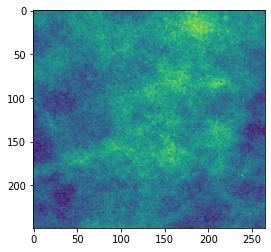

In [ ]:
import pydicom as dicom
import PIL # optional
import pandas as pd
import matplotlib.pyplot as plt

# specify your image path
image_path = '/content/1-1.dcm'
ds = dicom.dcmread(image_path)
plt.imshow( ds.pixel_array)

plt.show()